# **ROAD SEGMENTATION**

Khuzemah Hassan Qazi (24100092)

Ahmed Mukhtar Bhatti (24100079)

Credit to: https://github.com/kartik501/Road-Segmentation-for-Self-Driving-Cars/tree/main

**Accuracy Metrics:**
We used 2 metrics to evaluate our models: Intersection over Union (IoU) and Dice Score, both of which are metrics that quantify the degree of overlap in the true and the predicted image, where IoU is more sensitive to extreme values.
We also used these two metrics in one of our previous assignments.

Intersection over Union (IoU): This metric gives the ratio of intersection area of true and predicted image to the union area true and predicted image.

Dice Score: This metric gives the ratio of two times the intersection area of true and predicted image to the sum of areas true and predicted image.

### CODE

In [1]:
# Importing the CamVid3 data from https://drive.google.com/file/d/1vo7EieQITDVLIWcQvzzD3tWtlP5xKWYG/view?usp=share_link
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/My\ Drive/CV_Assignments/CamVid3.zip

Mounted at /content/drive
Archive:  drive/My Drive/CV_Assignments/CamVid3.zip
   creating: CamVid/test/
  inflating: CamVid/test/0001TP_008550.png  
  inflating: CamVid/test/0001TP_008580.png  
  inflating: CamVid/test/0001TP_008610.png  
  inflating: CamVid/test/0001TP_008640.png  
  inflating: CamVid/test/0001TP_008670.png  
  inflating: CamVid/test/0001TP_008700.png  
  inflating: CamVid/test/0001TP_008730.png  
  inflating: CamVid/test/0001TP_008760.png  
  inflating: CamVid/test/0001TP_008790.png  
  inflating: CamVid/test/0001TP_008820.png  
  inflating: CamVid/test/0001TP_008850.png  
  inflating: CamVid/test/0001TP_008880.png  
  inflating: CamVid/test/0001TP_008910.png  
  inflating: CamVid/test/0001TP_008940.png  
  inflating: CamVid/test/0001TP_008970.png  
  inflating: CamVid/test/0001TP_009000.png  
  inflating: CamVid/test/0001TP_009030.png  
  inflating: CamVid/test/0001TP_009060.png  
  inflating: CamVid/test/0001TP_009090.png  
  inflating: CamVid/test/0001TP_009120.pn

In [2]:
!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=dd5a4046d4ff45a0e17b98f06e36a4862da3a50cb05942b6cb0f46669a890255
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=506a8b5876b35b4b734cd4e0e6dd4372c2a55460c9036311b5bca774dbd7940d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [3]:
pip install pytorch-model-summary

In [4]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor

import os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, MaxUnpool2d, ReLU, BatchNorm2d, Dropout, Sigmoid
from pytorch_model_summary import summary

import torch
from numpy import asarray
import tensorflow as tf

import cv2
import numpy as np
from keras import backend as K

from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from random import random
from torchvision.transforms import functional as F

import segmentation_models_pytorch as smp

from torchvision.transforms import Normalize
from segmentation_models_pytorch import utils

In [35]:
x_train_dir = '/content/CamVid/train'
y_train_dir = '/content/CamVid/train_labels'
x_val_dir = '/content/CamVid/val'
y_val_dir = '/content/CamVid/val_labels'
x_test_dir = '/content/CamVid/test'
y_test_dir = '/content/CamVid/test_labels'

### 3.1 Define custom dataset

In [10]:
# custom dataset class with Data augmentation and normalization of images

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # Here we get names of all images
        self.image_names = os.listdir(images_dir)

        # Defining training type,transforms and preprocessing
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing=preprocessing

        # Definining paths of images and masks
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocessing of mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # Introducing data augmentation
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            image = self.transforms(image)
            mask = self.transforms(mask)

            ## apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
            return image, mask

        else:
            image = Image.open(self.images_paths[i])
            image = self.transforms(image)

            # apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
            return image

    def __len__(self):
        return len(self.image_names)

In [18]:
train_transforms = Compose([Resize((224, 224)),ToTensor()]) #resizing
train_dataset = CamVidDataset(x_train_dir, y_train_dir,
    transforms=train_transforms,training_type='train')#creating an instance of custom dataset
train_loader = DataLoader(train_dataset, batch_size=16,num_workers=2) # Load dataloader

### 3.2 Data Exploration

In [19]:
for batch_x, batch_y in train_loader:
    break
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

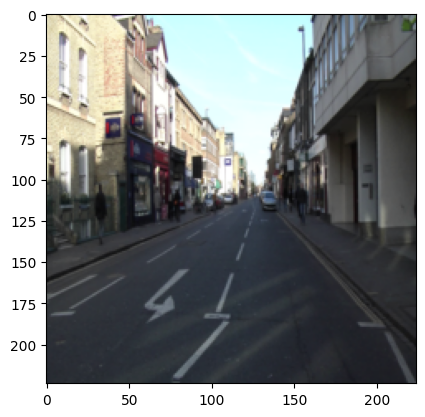

In [20]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

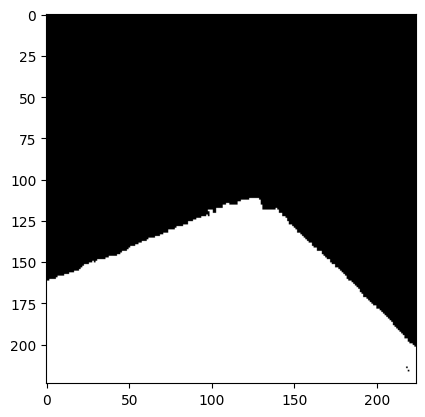

In [21]:
plt.imshow(batch_y[0].squeeze(), cmap='gray')

In [22]:

train_dataset = CamVidDataset(x_train_dir, y_train_dir,
    transforms=train_transforms,preprocessing=True,training_type='train')# create instance of custom dataset
#Creating the dataloader
train_loader = DataLoader(train_dataset,
    batch_size=16,num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 3.3 Define model architecture

In [23]:
# Create u-net with a pretrained encoder
model = smp.Unet(encoder_name='resnet18', encoder_weights='imagenet', classes=1, activation='sigmoid')
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.7MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [24]:
for batch_x, batch_y in train_loader:
    break
# Running model for one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

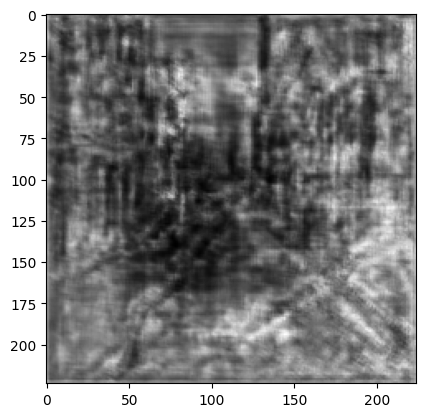

In [25]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

### 3.4 Train the model

In [26]:
import time
start_time = time.time()

criterion = smp.utils.losses.BCELoss() # Loss function
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3) #Optimizer
metrics = [smp.utils.metrics.IoU(threshold=0.5)] #Evaluation metric

train_epoch = smp.utils.train.TrainEpoch(
    model, loss=criterion, metrics=metrics, optimizer=optimizer,device='cuda',verbose=True,)

# Saving best model and Decrease in LR after 10th epoch added for U-Net model
max_score = 0

for i in range(0, 20):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    # decreasing learning rate after 10th epoch
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')

print("--- %s seconds ---" % (time.time() - start_time))


Epoch: 1
train: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s, bce_loss - 0.2496, iou_score - 0.8209]
Model saved!

Epoch: 2
train: 100%|██████████| 23/23 [00:04<00:00,  4.90it/s, bce_loss - 0.08844, iou_score - 0.9227]
Model saved!

Epoch: 3
train: 100%|██████████| 23/23 [00:04<00:00,  5.30it/s, bce_loss - 0.05988, iou_score - 0.9419]
Model saved!

Epoch: 4
train: 100%|██████████| 23/23 [00:05<00:00,  4.23it/s, bce_loss - 0.05327, iou_score - 0.9435]
Model saved!

Epoch: 5
train: 100%|██████████| 23/23 [00:05<00:00,  3.93it/s, bce_loss - 0.04474, iou_score - 0.9511]
Model saved!

Epoch: 6
train: 100%|██████████| 23/23 [00:04<00:00,  4.91it/s, bce_loss - 0.04087, iou_score - 0.9547]
Model saved!

Epoch: 7
train: 100%|██████████| 23/23 [00:04<00:00,  4.99it/s, bce_loss - 0.03659, iou_score - 0.9584]
Model saved!

Epoch: 8
train: 100%|██████████| 23/23 [00:07<00:00,  3.15it/s, bce_loss - 0.03792, iou_score - 0.9558]

Epoch: 9
train: 100%|██████████| 23/23 [00:04<00:00,  5.25it/s, bce_l

In [27]:
# Loading the best saved point
model = torch.load('./best_model.pth')

### 3.5 Testing the model on a single validation image

In [28]:
image = Image.open('/content/CamVid/val/0016E5_07987.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07987.png')

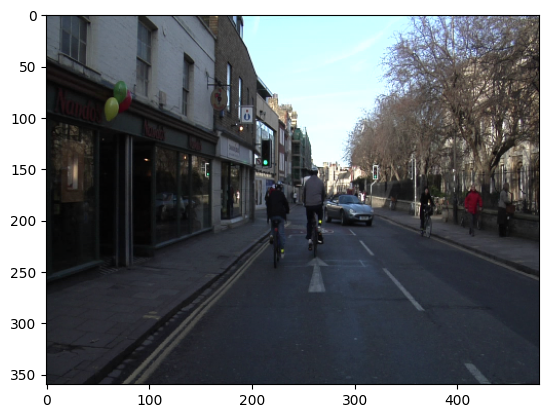

In [29]:
plt.imshow(image)

In [30]:
import time
start_time = time.time()

# preprocessing of mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# Preprocess
transform = Compose([Resize((224, 224)),ToTensor()]) #Resizing
image = transform(image)
image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
gt_mask = transform(gt_mask)

model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.10416793823242188 seconds ---


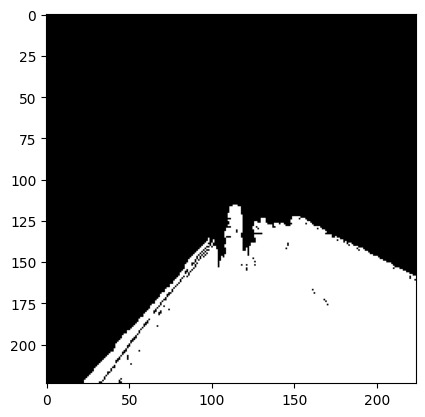

In [31]:
# Actual mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

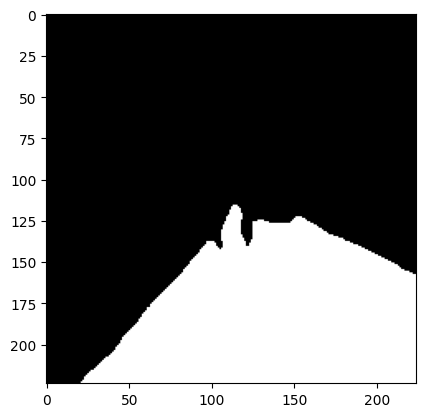

In [32]:
# predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [33]:
mask = (output.squeeze() > 0.5).astype(int) # Converting thr predicted mask to a flattened numpy array
pred = mask.ravel().copy()

gt_mask = gt_mask.cpu().detach().numpy() # converting the ground truth mask to flattened numpy array
target = gt_mask.ravel().copy().astype(int)

pred_inds = pred == 1 # getting class indices for Lane
target_inds = target == 1

intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection

#Defining IOP Score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9668805630304285

### 3.6 Mean IOU Score for validation set

In [36]:
valid_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir,
    transforms=valid_transforms,
    preprocessing=True,
    training_type='valid'
)

In [37]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [38]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()])

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

In [39]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.97095805

### 3.7 Mean Dice Score for validation set

In [41]:
def dice_coef(y_true, y_pred, smooth=1):


  intersection=(np.sum(np.array(y_pred[y_true==1])))*2
  dice = intersection / (np.sum(np.array(y_pred)) + np.sum(np.array(y_true)))
  return dice

In [42]:
T2 = []

for i in range(len(valid_dataset)):
  p2 = valid_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)


0.9789554684727468

# 4. Inference on test dataset (applying Model 3 - UNet)

### 4.1 Obtaining prediction masks for test set

In [43]:
test_transforms = Compose([Resize((224, 224)), ToTensor()]) #resize

test_dataset = CamVidDataset(x_test_dir, transforms=test_transforms,preprocessing=True,training_type='test')

In [44]:
# running the model for all images in test dataset
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

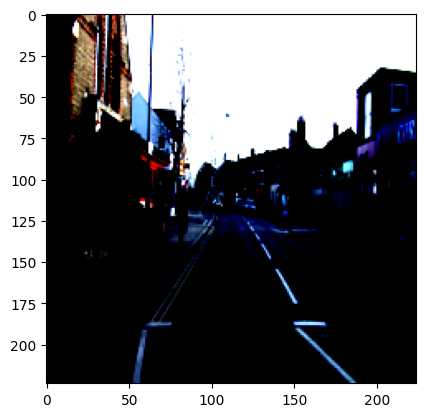

In [45]:
# display image(original)
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

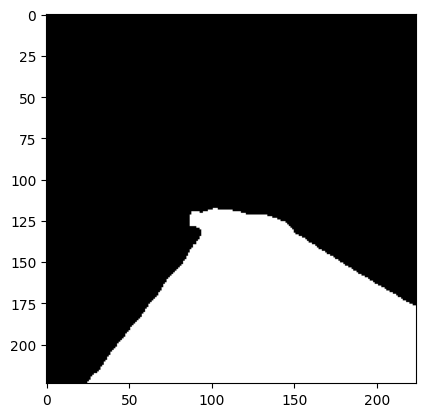

In [46]:
# display prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')

### 4.2 True mask for test set

In [47]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()]) #resizw
image_names = os.listdir(y_test_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_test_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

### 4.3 Mean IOU score for test set

In [48]:
T = []

for i in range(len(test_dataset)):
  p = test_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.928103

### 4.4 Mean Dice score for test set

In [49]:
T2 = []

for i in range(len(test_dataset)):
  p2 = test_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)

0.941089399583219